In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 1
DATASET_VERSION = "08"

In [4]:
OOF_PATH = Path(f"../data/oof/lgbm-dart-bce-dsv{DATASET_VERSION}")
SUB_PATH = Path(f"../data/subs/lgbm-dart-bce-dsv{DATASET_VERSION}")
ART_PATH = Path(f"../artifacts/lgbm-dart-bce-dsv{DATASET_VERSION}")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
len(input_feats)

1049

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'boosting': 'dart',
    'objective': 'binary',
    'metric': 'None',
    'num_iterations': 4350,
    'num_leaves': 15,
    'learning_rate': 0.05,
    'max_bin': 63,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 1.0,
    'feature_fraction': 0.15,
    'lambda_l1': 5.996099571922015,
    'lambda_l2': 2.8900783163910697,
    'min_data_in_leaf': 1000,
    'path_smooth': 1.476306537276899,
    'min_gain_to_split': 0.313937968985787,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': True,
    'verbosity': -1,
    # dropout params
    'drop_rate': 0.1,
    'max_drop': 40,
    'skip_drop': 0.7,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            free_raw_data=True,
        )
                
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [10]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/1 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.751735	valid_0's recall_at4: 0.604393	valid_0's norm_gini: 0.899078


[100]	valid_0's amex_metric: 0.761363	valid_0's recall_at4: 0.617773	valid_0's norm_gini: 0.904952


[150]	valid_0's amex_metric: 0.768546	valid_0's recall_at4: 0.628208	valid_0's norm_gini: 0.908884


[200]	valid_0's amex_metric: 0.774447	valid_0's recall_at4: 0.636371	valid_0's norm_gini: 0.912523


[250]	valid_0's amex_metric: 0.778356	valid_0's recall_at4: 0.641589	valid_0's norm_gini: 0.915123


[300]	valid_0's amex_metric: 0.781778	valid_0's recall_at4: 0.646848	valid_0's norm_gini: 0.916707


[350]	valid_0's amex_metric: 0.784394	valid_0's recall_at4: 0.650846	valid_0's norm_gini: 0.917943


[400]	valid_0's amex_metric: 0.785604	valid_0's recall_at4: 0.65236	valid_0's norm_gini: 0.918848


[450]	valid_0's amex_metric: 0.786751	valid_0's recall_at4: 0.653833	valid_0's norm_gini: 0.919668


[500]	valid_0's amex_metric: 0.787872	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.920143


[550]	valid_0's amex_metric: 0.788346	valid_0's recall_at4: 0.656105	valid_0's norm_gini: 0.920586


[600]	valid_0's amex_metric: 0.789266	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.920911


[650]	valid_0's amex_metric: 0.789618	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.921238


[700]	valid_0's amex_metric: 0.790611	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.921541


[750]	valid_0's amex_metric: 0.791092	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.921786


[800]	valid_0's amex_metric: 0.791494	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.921959


[850]	valid_0's amex_metric: 0.791544	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.922185


[900]	valid_0's amex_metric: 0.792741	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.92235


[950]	valid_0's amex_metric: 0.79318	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.922554


[1000]	valid_0's amex_metric: 0.79345	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.922757


[1050]	valid_0's amex_metric: 0.793652	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.922951


[1100]	valid_0's amex_metric: 0.793923	valid_0's recall_at4: 0.664731	valid_0's norm_gini: 0.923116


[1150]	valid_0's amex_metric: 0.793971	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.923253


[1200]	valid_0's amex_metric: 0.794329	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.92338


[1250]	valid_0's amex_metric: 0.795159	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.923484


[1300]	valid_0's amex_metric: 0.795423	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.923548


[1350]	valid_0's amex_metric: 0.795584	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.923617


[1400]	valid_0's amex_metric: 0.795588	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.923668


[1450]	valid_0's amex_metric: 0.795226	valid_0's recall_at4: 0.666709	valid_0's norm_gini: 0.923743


[1500]	valid_0's amex_metric: 0.795263	valid_0's recall_at4: 0.666709	valid_0's norm_gini: 0.923818


[1550]	valid_0's amex_metric: 0.794819	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.923896


[1600]	valid_0's amex_metric: 0.795072	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.92394


[1650]	valid_0's amex_metric: 0.795001	valid_0's recall_at4: 0.665993	valid_0's norm_gini: 0.924008


[1700]	valid_0's amex_metric: 0.795186	valid_0's recall_at4: 0.66633	valid_0's norm_gini: 0.924043


[1750]	valid_0's amex_metric: 0.794883	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.92411


[1800]	valid_0's amex_metric: 0.794931	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.924164


[1850]	valid_0's amex_metric: 0.794827	valid_0's recall_at4: 0.665446	valid_0's norm_gini: 0.924208


[1900]	valid_0's amex_metric: 0.794749	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.92422


[1950]	valid_0's amex_metric: 0.79505	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924275


[2000]	valid_0's amex_metric: 0.7951	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.924291


[2050]	valid_0's amex_metric: 0.795152	valid_0's recall_at4: 0.665993	valid_0's norm_gini: 0.92431


[2100]	valid_0's amex_metric: 0.795156	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.92436


[2150]	valid_0's amex_metric: 0.795181	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.924412


[2200]	valid_0's amex_metric: 0.795625	valid_0's recall_at4: 0.666793	valid_0's norm_gini: 0.924457


[2250]	valid_0's amex_metric: 0.795087	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.924474


[2300]	valid_0's amex_metric: 0.795261	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.924486


[2350]	valid_0's amex_metric: 0.795241	valid_0's recall_at4: 0.665993	valid_0's norm_gini: 0.924489


[2400]	valid_0's amex_metric: 0.79507	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.924524


[2450]	valid_0's amex_metric: 0.79537	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.924536


[2500]	valid_0's amex_metric: 0.795608	valid_0's recall_at4: 0.666709	valid_0's norm_gini: 0.924508


[2550]	valid_0's amex_metric: 0.795593	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924519


[2600]	valid_0's amex_metric: 0.795707	valid_0's recall_at4: 0.666877	valid_0's norm_gini: 0.924536


[2650]	valid_0's amex_metric: 0.796284	valid_0's recall_at4: 0.668013	valid_0's norm_gini: 0.924555


[2700]	valid_0's amex_metric: 0.796455	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.924561


[2750]	valid_0's amex_metric: 0.796231	valid_0's recall_at4: 0.667887	valid_0's norm_gini: 0.924574


[2800]	valid_0's amex_metric: 0.796037	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924565


[2850]	valid_0's amex_metric: 0.79602	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.924575


[2900]	valid_0's amex_metric: 0.795665	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.924579


[2950]	valid_0's amex_metric: 0.795629	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924591


[3000]	valid_0's amex_metric: 0.795166	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.924591


[3050]	valid_0's amex_metric: 0.795227	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.924586


[3100]	valid_0's amex_metric: 0.794981	valid_0's recall_at4: 0.665362	valid_0's norm_gini: 0.924599


[3150]	valid_0's amex_metric: 0.794869	valid_0's recall_at4: 0.665152	valid_0's norm_gini: 0.924586


[3200]	valid_0's amex_metric: 0.795142	valid_0's recall_at4: 0.665699	valid_0's norm_gini: 0.924585


[3250]	valid_0's amex_metric: 0.794988	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.924571


[3300]	valid_0's amex_metric: 0.795174	valid_0's recall_at4: 0.665783	valid_0's norm_gini: 0.924564


[3350]	valid_0's amex_metric: 0.795083	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.924552


[3400]	valid_0's amex_metric: 0.79477	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924556


[3450]	valid_0's amex_metric: 0.794674	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.924574


[3500]	valid_0's amex_metric: 0.79508	valid_0's recall_at4: 0.665573	valid_0's norm_gini: 0.924588


[3550]	valid_0's amex_metric: 0.794725	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.924592


[3600]	valid_0's amex_metric: 0.794797	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924609


[3650]	valid_0's amex_metric: 0.794738	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.924618


[3700]	valid_0's amex_metric: 0.794406	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.924627


[3750]	valid_0's amex_metric: 0.794422	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.924618


[3800]	valid_0's amex_metric: 0.794854	valid_0's recall_at4: 0.66511	valid_0's norm_gini: 0.924597


[3850]	valid_0's amex_metric: 0.79471	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.924604


[3900]	valid_0's amex_metric: 0.794793	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924603


[3950]	valid_0's amex_metric: 0.794755	valid_0's recall_at4: 0.664899	valid_0's norm_gini: 0.924611


[4000]	valid_0's amex_metric: 0.794776	valid_0's recall_at4: 0.664941	valid_0's norm_gini: 0.924611


[4050]	valid_0's amex_metric: 0.795046	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.924603


[4100]	valid_0's amex_metric: 0.795244	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.92462


[4150]	valid_0's amex_metric: 0.794597	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.924631


[4200]	valid_0's amex_metric: 0.795092	valid_0's recall_at4: 0.665531	valid_0's norm_gini: 0.924653


[4250]	valid_0's amex_metric: 0.794964	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.92465


[4300]	valid_0's amex_metric: 0.794763	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.924668


[4350]	valid_0's amex_metric: 0.79451	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.924667


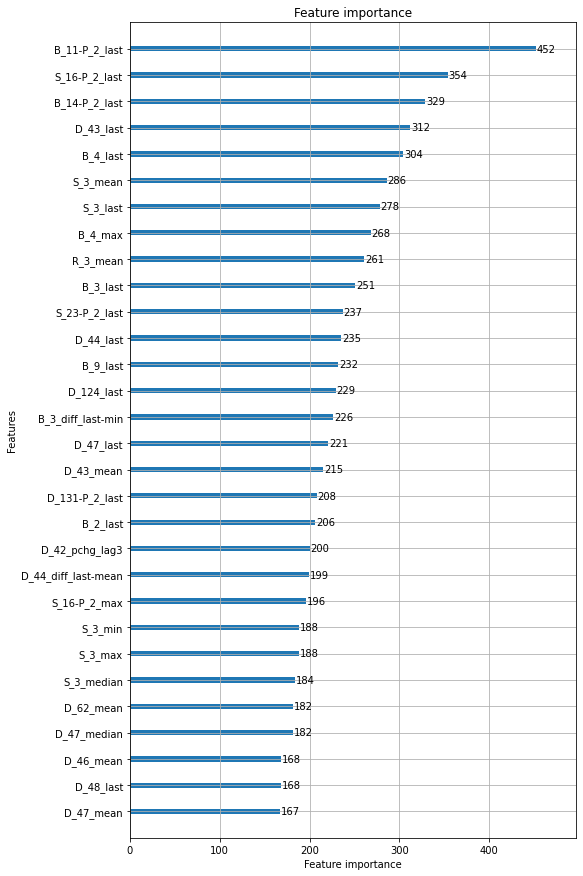

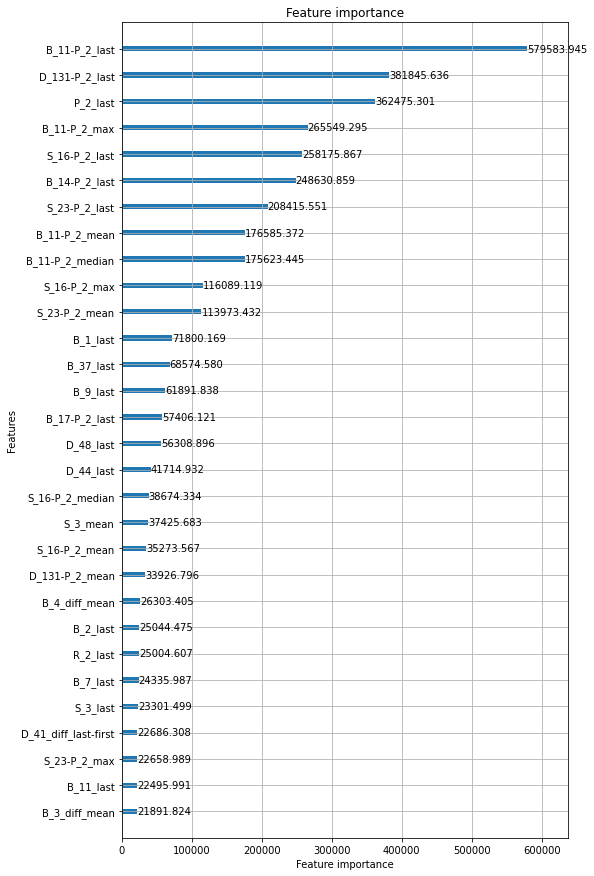

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.749967	valid_0's recall_at4: 0.601532	valid_0's norm_gini: 0.898403


[100]	valid_0's amex_metric: 0.758368	valid_0's recall_at4: 0.612892	valid_0's norm_gini: 0.903844


[150]	valid_0's amex_metric: 0.764494	valid_0's recall_at4: 0.621392	valid_0's norm_gini: 0.907596


[200]	valid_0's amex_metric: 0.771471	valid_0's recall_at4: 0.631659	valid_0's norm_gini: 0.911283


[250]	valid_0's amex_metric: 0.775519	valid_0's recall_at4: 0.637381	valid_0's norm_gini: 0.913656


[300]	valid_0's amex_metric: 0.778258	valid_0's recall_at4: 0.64121	valid_0's norm_gini: 0.915305


[350]	valid_0's amex_metric: 0.780408	valid_0's recall_at4: 0.644282	valid_0's norm_gini: 0.916535


[400]	valid_0's amex_metric: 0.782236	valid_0's recall_at4: 0.646975	valid_0's norm_gini: 0.917497


[450]	valid_0's amex_metric: 0.784053	valid_0's recall_at4: 0.649836	valid_0's norm_gini: 0.918269


[500]	valid_0's amex_metric: 0.7848	valid_0's recall_at4: 0.650762	valid_0's norm_gini: 0.918838


[550]	valid_0's amex_metric: 0.786234	valid_0's recall_at4: 0.653118	valid_0's norm_gini: 0.91935


[600]	valid_0's amex_metric: 0.786839	valid_0's recall_at4: 0.654002	valid_0's norm_gini: 0.919676


[650]	valid_0's amex_metric: 0.787278	valid_0's recall_at4: 0.654506	valid_0's norm_gini: 0.92005


[700]	valid_0's amex_metric: 0.788016	valid_0's recall_at4: 0.655685	valid_0's norm_gini: 0.920347


[750]	valid_0's amex_metric: 0.78817	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.920613


[800]	valid_0's amex_metric: 0.78906	valid_0's recall_at4: 0.657326	valid_0's norm_gini: 0.920795


[850]	valid_0's amex_metric: 0.789236	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.921063


[900]	valid_0's amex_metric: 0.789372	valid_0's recall_at4: 0.657494	valid_0's norm_gini: 0.921251


[950]	valid_0's amex_metric: 0.789991	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.921479


[1000]	valid_0's amex_metric: 0.790303	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.921724


[1050]	valid_0's amex_metric: 0.790944	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.921953


[1100]	valid_0's amex_metric: 0.791067	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.922199


[1150]	valid_0's amex_metric: 0.791008	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.922334


[1200]	valid_0's amex_metric: 0.791277	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.922451


[1250]	valid_0's amex_metric: 0.791167	valid_0's recall_at4: 0.659766	valid_0's norm_gini: 0.922567


[1300]	valid_0's amex_metric: 0.791626	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.922645


[1350]	valid_0's amex_metric: 0.791373	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.922728


[1400]	valid_0's amex_metric: 0.791586	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.922817


[1450]	valid_0's amex_metric: 0.791991	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.922912


[1500]	valid_0's amex_metric: 0.792205	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.923002


[1550]	valid_0's amex_metric: 0.792482	valid_0's recall_at4: 0.66187	valid_0's norm_gini: 0.923094


[1600]	valid_0's amex_metric: 0.792671	valid_0's recall_at4: 0.662164	valid_0's norm_gini: 0.923177


[1650]	valid_0's amex_metric: 0.792592	valid_0's recall_at4: 0.661954	valid_0's norm_gini: 0.923229


[1700]	valid_0's amex_metric: 0.792993	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.923274


[1750]	valid_0's amex_metric: 0.79319	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.923331


[1800]	valid_0's amex_metric: 0.793239	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.923388


[1850]	valid_0's amex_metric: 0.793463	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.923416


[1900]	valid_0's amex_metric: 0.793124	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.923452


[1950]	valid_0's amex_metric: 0.793157	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.923518


[2000]	valid_0's amex_metric: 0.793384	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.923552


[2050]	valid_0's amex_metric: 0.793879	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.923574


[2100]	valid_0's amex_metric: 0.793935	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.923602


[2150]	valid_0's amex_metric: 0.793893	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.923643


[2200]	valid_0's amex_metric: 0.794175	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.923661


[2250]	valid_0's amex_metric: 0.793914	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.923685


[2300]	valid_0's amex_metric: 0.794311	valid_0's recall_at4: 0.664899	valid_0's norm_gini: 0.923722


[2350]	valid_0's amex_metric: 0.794479	valid_0's recall_at4: 0.665194	valid_0's norm_gini: 0.923765


[2400]	valid_0's amex_metric: 0.794446	valid_0's recall_at4: 0.66511	valid_0's norm_gini: 0.923782


[2450]	valid_0's amex_metric: 0.794289	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.923805


[2500]	valid_0's amex_metric: 0.794207	valid_0's recall_at4: 0.664605	valid_0's norm_gini: 0.923809


[2550]	valid_0's amex_metric: 0.794115	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.923836


[2600]	valid_0's amex_metric: 0.794323	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.923872


[2650]	valid_0's amex_metric: 0.794583	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.923889


[2700]	valid_0's amex_metric: 0.794122	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.923891


[2750]	valid_0's amex_metric: 0.794494	valid_0's recall_at4: 0.665068	valid_0's norm_gini: 0.923921


[2800]	valid_0's amex_metric: 0.794519	valid_0's recall_at4: 0.66511	valid_0's norm_gini: 0.923928


[2850]	valid_0's amex_metric: 0.794549	valid_0's recall_at4: 0.665152	valid_0's norm_gini: 0.923945


[2900]	valid_0's amex_metric: 0.794558	valid_0's recall_at4: 0.665152	valid_0's norm_gini: 0.923964


[2950]	valid_0's amex_metric: 0.7949	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.923974


[3000]	valid_0's amex_metric: 0.794807	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.923998


[3050]	valid_0's amex_metric: 0.79462	valid_0's recall_at4: 0.665236	valid_0's norm_gini: 0.924003


[3100]	valid_0's amex_metric: 0.795064	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.924009


[3150]	valid_0's amex_metric: 0.794562	valid_0's recall_at4: 0.66511	valid_0's norm_gini: 0.924014


[3200]	valid_0's amex_metric: 0.795034	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.924033


[3250]	valid_0's amex_metric: 0.794894	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.924046


[3300]	valid_0's amex_metric: 0.794943	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924061


[3350]	valid_0's amex_metric: 0.794939	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924053


[3400]	valid_0's amex_metric: 0.794645	valid_0's recall_at4: 0.665236	valid_0's norm_gini: 0.924054


[3450]	valid_0's amex_metric: 0.795094	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.924068


[3500]	valid_0's amex_metric: 0.794939	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924052


[3550]	valid_0's amex_metric: 0.794755	valid_0's recall_at4: 0.665446	valid_0's norm_gini: 0.924064


[3600]	valid_0's amex_metric: 0.795114	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.924066


[3650]	valid_0's amex_metric: 0.795499	valid_0's recall_at4: 0.666919	valid_0's norm_gini: 0.92408


[3700]	valid_0's amex_metric: 0.795468	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.924101


[3750]	valid_0's amex_metric: 0.795457	valid_0's recall_at4: 0.666793	valid_0's norm_gini: 0.924121


[3800]	valid_0's amex_metric: 0.795701	valid_0's recall_at4: 0.667256	valid_0's norm_gini: 0.924146


[3850]	valid_0's amex_metric: 0.795429	valid_0's recall_at4: 0.666709	valid_0's norm_gini: 0.92415


[3900]	valid_0's amex_metric: 0.795909	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.924141


[3950]	valid_0's amex_metric: 0.795813	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924117


[4000]	valid_0's amex_metric: 0.795812	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924115


[4050]	valid_0's amex_metric: 0.795805	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924102


[4100]	valid_0's amex_metric: 0.795507	valid_0's recall_at4: 0.666919	valid_0's norm_gini: 0.924094


[4150]	valid_0's amex_metric: 0.795819	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.92413


[4200]	valid_0's amex_metric: 0.795825	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924141


[4250]	valid_0's amex_metric: 0.796248	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.924146


[4300]	valid_0's amex_metric: 0.796251	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.924153


[4350]	valid_0's amex_metric: 0.795977	valid_0's recall_at4: 0.667803	valid_0's norm_gini: 0.924152


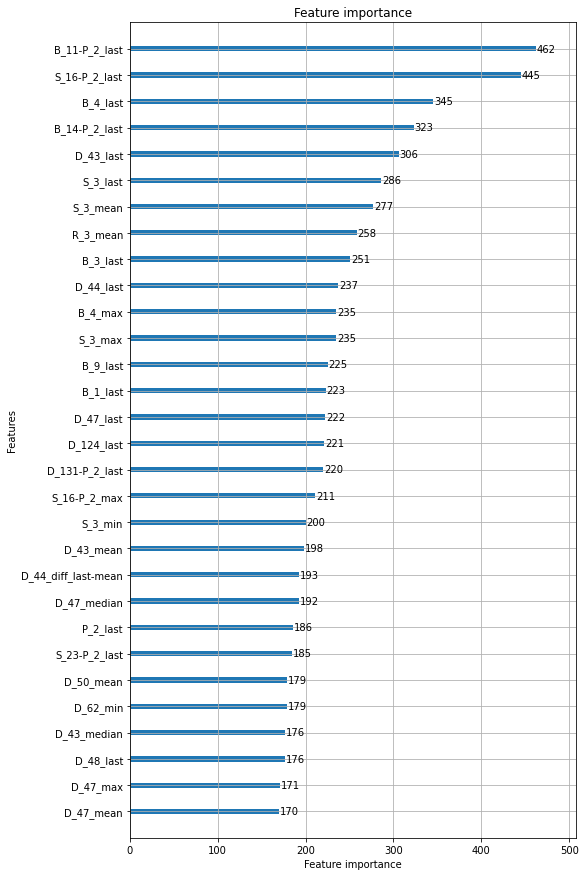

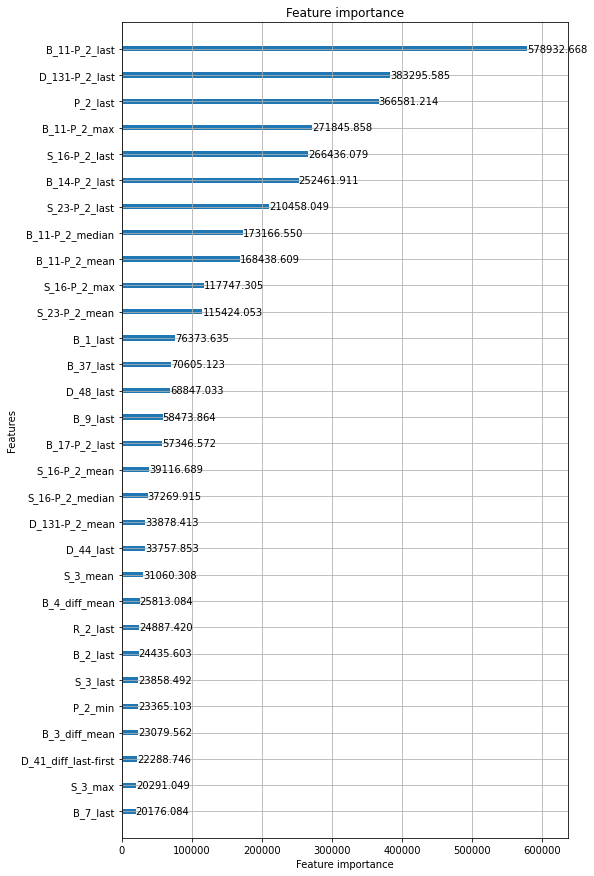

######################################## training model 3/5 ########################################


[50]	valid_0's amex_metric: 0.743006	valid_0's recall_at4: 0.588698	valid_0's norm_gini: 0.897314


[100]	valid_0's amex_metric: 0.752808	valid_0's recall_at4: 0.602626	valid_0's norm_gini: 0.90299


[150]	valid_0's amex_metric: 0.759738	valid_0's recall_at4: 0.612724	valid_0's norm_gini: 0.906751


[200]	valid_0's amex_metric: 0.765887	valid_0's recall_at4: 0.621392	valid_0's norm_gini: 0.910382


[250]	valid_0's amex_metric: 0.769618	valid_0's recall_at4: 0.626441	valid_0's norm_gini: 0.912795


[300]	valid_0's amex_metric: 0.773541	valid_0's recall_at4: 0.632753	valid_0's norm_gini: 0.91433


[350]	valid_0's amex_metric: 0.775111	valid_0's recall_at4: 0.634646	valid_0's norm_gini: 0.915575


[400]	valid_0's amex_metric: 0.777384	valid_0's recall_at4: 0.638307	valid_0's norm_gini: 0.916461


[450]	valid_0's amex_metric: 0.778792	valid_0's recall_at4: 0.640326	valid_0's norm_gini: 0.917258


[500]	valid_0's amex_metric: 0.779941	valid_0's recall_at4: 0.642052	valid_0's norm_gini: 0.91783


[550]	valid_0's amex_metric: 0.780932	valid_0's recall_at4: 0.643566	valid_0's norm_gini: 0.918298


[600]	valid_0's amex_metric: 0.781159	valid_0's recall_at4: 0.643735	valid_0's norm_gini: 0.918583


[650]	valid_0's amex_metric: 0.78241	valid_0's recall_at4: 0.645923	valid_0's norm_gini: 0.918897


[700]	valid_0's amex_metric: 0.782943	valid_0's recall_at4: 0.646638	valid_0's norm_gini: 0.919249


[750]	valid_0's amex_metric: 0.783355	valid_0's recall_at4: 0.647227	valid_0's norm_gini: 0.919482


[800]	valid_0's amex_metric: 0.784043	valid_0's recall_at4: 0.648405	valid_0's norm_gini: 0.91968


[850]	valid_0's amex_metric: 0.784562	valid_0's recall_at4: 0.649205	valid_0's norm_gini: 0.91992


[900]	valid_0's amex_metric: 0.784775	valid_0's recall_at4: 0.649457	valid_0's norm_gini: 0.920094


[950]	valid_0's amex_metric: 0.785548	valid_0's recall_at4: 0.650762	valid_0's norm_gini: 0.920334


[1000]	valid_0's amex_metric: 0.785846	valid_0's recall_at4: 0.65114	valid_0's norm_gini: 0.920551


[1050]	valid_0's amex_metric: 0.785427	valid_0's recall_at4: 0.650088	valid_0's norm_gini: 0.920766


[1100]	valid_0's amex_metric: 0.786214	valid_0's recall_at4: 0.651477	valid_0's norm_gini: 0.920951


[1150]	valid_0's amex_metric: 0.786319	valid_0's recall_at4: 0.651561	valid_0's norm_gini: 0.921078


[1200]	valid_0's amex_metric: 0.786475	valid_0's recall_at4: 0.651729	valid_0's norm_gini: 0.92122


[1250]	valid_0's amex_metric: 0.78685	valid_0's recall_at4: 0.652403	valid_0's norm_gini: 0.921298


[1300]	valid_0's amex_metric: 0.787044	valid_0's recall_at4: 0.652697	valid_0's norm_gini: 0.921391


[1350]	valid_0's amex_metric: 0.787176	valid_0's recall_at4: 0.652907	valid_0's norm_gini: 0.921445


[1400]	valid_0's amex_metric: 0.787676	valid_0's recall_at4: 0.653833	valid_0's norm_gini: 0.921519


[1450]	valid_0's amex_metric: 0.788066	valid_0's recall_at4: 0.654549	valid_0's norm_gini: 0.921584


[1500]	valid_0's amex_metric: 0.788101	valid_0's recall_at4: 0.654549	valid_0's norm_gini: 0.921653


[1550]	valid_0's amex_metric: 0.788087	valid_0's recall_at4: 0.654422	valid_0's norm_gini: 0.921753


[1600]	valid_0's amex_metric: 0.788432	valid_0's recall_at4: 0.655053	valid_0's norm_gini: 0.921811


[1650]	valid_0's amex_metric: 0.788235	valid_0's recall_at4: 0.654591	valid_0's norm_gini: 0.921879


[1700]	valid_0's amex_metric: 0.78865	valid_0's recall_at4: 0.655348	valid_0's norm_gini: 0.921951


[1750]	valid_0's amex_metric: 0.788968	valid_0's recall_at4: 0.655937	valid_0's norm_gini: 0.921998


[1800]	valid_0's amex_metric: 0.789057	valid_0's recall_at4: 0.656063	valid_0's norm_gini: 0.922051


[1850]	valid_0's amex_metric: 0.789331	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.922093


[1900]	valid_0's amex_metric: 0.789408	valid_0's recall_at4: 0.656694	valid_0's norm_gini: 0.922123


[1950]	valid_0's amex_metric: 0.789376	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.922183


[2000]	valid_0's amex_metric: 0.789589	valid_0's recall_at4: 0.656989	valid_0's norm_gini: 0.922188


[2050]	valid_0's amex_metric: 0.789818	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.922226


[2100]	valid_0's amex_metric: 0.789398	valid_0's recall_at4: 0.656526	valid_0's norm_gini: 0.922269


[2150]	valid_0's amex_metric: 0.789757	valid_0's recall_at4: 0.657199	valid_0's norm_gini: 0.922315


[2200]	valid_0's amex_metric: 0.7902	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.92236


[2250]	valid_0's amex_metric: 0.790318	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.922386


[2300]	valid_0's amex_metric: 0.790019	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.922418


[2350]	valid_0's amex_metric: 0.79035	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.922448


[2400]	valid_0's amex_metric: 0.790212	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.922467


[2450]	valid_0's amex_metric: 0.789911	valid_0's recall_at4: 0.657326	valid_0's norm_gini: 0.922496


[2500]	valid_0's amex_metric: 0.790131	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.922516


[2550]	valid_0's amex_metric: 0.789954	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.922497


[2600]	valid_0's amex_metric: 0.789874	valid_0's recall_at4: 0.657241	valid_0's norm_gini: 0.922506


[2650]	valid_0's amex_metric: 0.789956	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.922503


[2700]	valid_0's amex_metric: 0.789968	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.922526


[2750]	valid_0's amex_metric: 0.790113	valid_0's recall_at4: 0.657662	valid_0's norm_gini: 0.922564


[2800]	valid_0's amex_metric: 0.790198	valid_0's recall_at4: 0.657831	valid_0's norm_gini: 0.922566


[2850]	valid_0's amex_metric: 0.790308	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.922576


[2900]	valid_0's amex_metric: 0.790793	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.922577


[2950]	valid_0's amex_metric: 0.790464	valid_0's recall_at4: 0.658335	valid_0's norm_gini: 0.922593


[3000]	valid_0's amex_metric: 0.790709	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.922619


[3050]	valid_0's amex_metric: 0.790508	valid_0's recall_at4: 0.658378	valid_0's norm_gini: 0.922639


[3100]	valid_0's amex_metric: 0.791158	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.922634


[3150]	valid_0's amex_metric: 0.7909	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.922624


[3200]	valid_0's amex_metric: 0.791363	valid_0's recall_at4: 0.660061	valid_0's norm_gini: 0.922666


[3250]	valid_0's amex_metric: 0.790958	valid_0's recall_at4: 0.659261	valid_0's norm_gini: 0.922656


[3300]	valid_0's amex_metric: 0.790943	valid_0's recall_at4: 0.659219	valid_0's norm_gini: 0.922667


[3350]	valid_0's amex_metric: 0.790981	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.922658


[3400]	valid_0's amex_metric: 0.790713	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.92267


[3450]	valid_0's amex_metric: 0.790984	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.922664


[3500]	valid_0's amex_metric: 0.791258	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.922665


[3550]	valid_0's amex_metric: 0.791187	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.922692


[3600]	valid_0's amex_metric: 0.791125	valid_0's recall_at4: 0.659556	valid_0's norm_gini: 0.922694


[3650]	valid_0's amex_metric: 0.791106	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.922698


[3700]	valid_0's amex_metric: 0.791357	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.922695


[3750]	valid_0's amex_metric: 0.791566	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.922693


[3800]	valid_0's amex_metric: 0.791594	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.922706


[3850]	valid_0's amex_metric: 0.791322	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.92271


[3900]	valid_0's amex_metric: 0.791466	valid_0's recall_at4: 0.660229	valid_0's norm_gini: 0.922703


[3950]	valid_0's amex_metric: 0.791316	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.922697


[4000]	valid_0's amex_metric: 0.790913	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.922691


[4050]	valid_0's amex_metric: 0.790568	valid_0's recall_at4: 0.658462	valid_0's norm_gini: 0.922675


[4100]	valid_0's amex_metric: 0.790471	valid_0's recall_at4: 0.658293	valid_0's norm_gini: 0.922649


[4150]	valid_0's amex_metric: 0.79095	valid_0's recall_at4: 0.659261	valid_0's norm_gini: 0.922638


[4200]	valid_0's amex_metric: 0.790716	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.922634


[4250]	valid_0's amex_metric: 0.790842	valid_0's recall_at4: 0.659051	valid_0's norm_gini: 0.922633


[4300]	valid_0's amex_metric: 0.790676	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.922638


[4350]	valid_0's amex_metric: 0.790858	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.922622


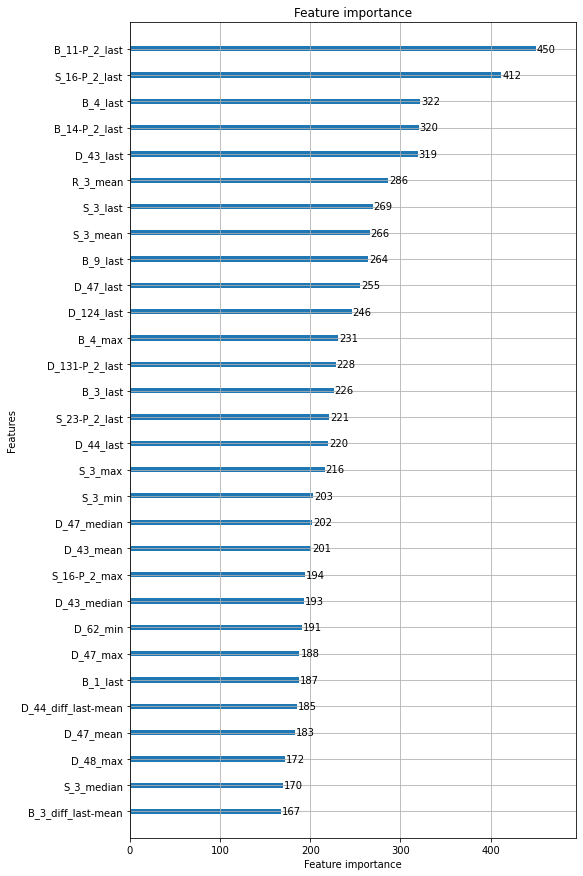

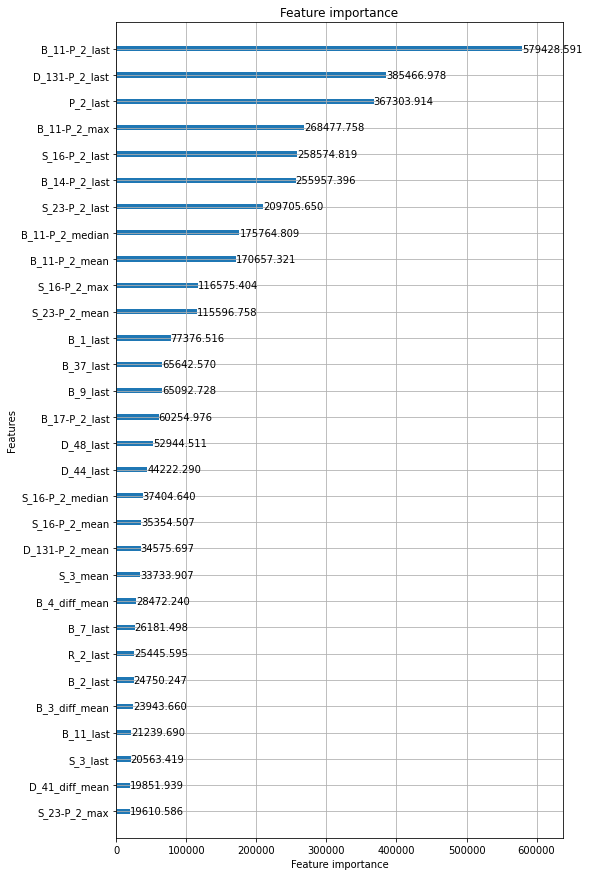

######################################## training model 4/5 ########################################


[50]	valid_0's amex_metric: 0.744511	valid_0's recall_at4: 0.592257	valid_0's norm_gini: 0.896764


[100]	valid_0's amex_metric: 0.755162	valid_0's recall_at4: 0.607406	valid_0's norm_gini: 0.902917


[150]	valid_0's amex_metric: 0.761157	valid_0's recall_at4: 0.615822	valid_0's norm_gini: 0.906492


[200]	valid_0's amex_metric: 0.767442	valid_0's recall_at4: 0.624826	valid_0's norm_gini: 0.910058


[250]	valid_0's amex_metric: 0.771338	valid_0's recall_at4: 0.630128	valid_0's norm_gini: 0.912548


[300]	valid_0's amex_metric: 0.774052	valid_0's recall_at4: 0.633789	valid_0's norm_gini: 0.914315


[350]	valid_0's amex_metric: 0.775984	valid_0's recall_at4: 0.636398	valid_0's norm_gini: 0.915571


[400]	valid_0's amex_metric: 0.777119	valid_0's recall_at4: 0.63766	valid_0's norm_gini: 0.916577


[450]	valid_0's amex_metric: 0.779006	valid_0's recall_at4: 0.640606	valid_0's norm_gini: 0.917407


[500]	valid_0's amex_metric: 0.779427	valid_0's recall_at4: 0.640858	valid_0's norm_gini: 0.917995


[550]	valid_0's amex_metric: 0.780169	valid_0's recall_at4: 0.641826	valid_0's norm_gini: 0.918512


[600]	valid_0's amex_metric: 0.781352	valid_0's recall_at4: 0.643846	valid_0's norm_gini: 0.918858


[650]	valid_0's amex_metric: 0.782127	valid_0's recall_at4: 0.645066	valid_0's norm_gini: 0.919188


[700]	valid_0's amex_metric: 0.782201	valid_0's recall_at4: 0.644814	valid_0's norm_gini: 0.919589


[750]	valid_0's amex_metric: 0.782587	valid_0's recall_at4: 0.645319	valid_0's norm_gini: 0.919854


[800]	valid_0's amex_metric: 0.78271	valid_0's recall_at4: 0.645361	valid_0's norm_gini: 0.920059


[850]	valid_0's amex_metric: 0.782781	valid_0's recall_at4: 0.645235	valid_0's norm_gini: 0.920327


[900]	valid_0's amex_metric: 0.783112	valid_0's recall_at4: 0.645697	valid_0's norm_gini: 0.920527


[950]	valid_0's amex_metric: 0.783785	valid_0's recall_at4: 0.646792	valid_0's norm_gini: 0.920778


[1000]	valid_0's amex_metric: 0.78443	valid_0's recall_at4: 0.647843	valid_0's norm_gini: 0.921017


[1050]	valid_0's amex_metric: 0.784945	valid_0's recall_at4: 0.648643	valid_0's norm_gini: 0.921247


[1100]	valid_0's amex_metric: 0.785452	valid_0's recall_at4: 0.649442	valid_0's norm_gini: 0.921461


[1150]	valid_0's amex_metric: 0.785306	valid_0's recall_at4: 0.649022	valid_0's norm_gini: 0.92159


[1200]	valid_0's amex_metric: 0.785771	valid_0's recall_at4: 0.649821	valid_0's norm_gini: 0.92172


[1250]	valid_0's amex_metric: 0.786447	valid_0's recall_at4: 0.651041	valid_0's norm_gini: 0.921853


[1300]	valid_0's amex_metric: 0.78659	valid_0's recall_at4: 0.651252	valid_0's norm_gini: 0.921928


[1350]	valid_0's amex_metric: 0.787018	valid_0's recall_at4: 0.652051	valid_0's norm_gini: 0.921985


[1400]	valid_0's amex_metric: 0.787103	valid_0's recall_at4: 0.652135	valid_0's norm_gini: 0.922071


[1450]	valid_0's amex_metric: 0.7877	valid_0's recall_at4: 0.65323	valid_0's norm_gini: 0.922171


[1500]	valid_0's amex_metric: 0.787957	valid_0's recall_at4: 0.65365	valid_0's norm_gini: 0.922264


[1550]	valid_0's amex_metric: 0.787888	valid_0's recall_at4: 0.65344	valid_0's norm_gini: 0.922337


[1600]	valid_0's amex_metric: 0.788353	valid_0's recall_at4: 0.654324	valid_0's norm_gini: 0.922383


[1650]	valid_0's amex_metric: 0.78804	valid_0's recall_at4: 0.653608	valid_0's norm_gini: 0.922472


[1700]	valid_0's amex_metric: 0.787884	valid_0's recall_at4: 0.65323	valid_0's norm_gini: 0.922538


[1750]	valid_0's amex_metric: 0.787777	valid_0's recall_at4: 0.652977	valid_0's norm_gini: 0.922576


[1800]	valid_0's amex_metric: 0.78774	valid_0's recall_at4: 0.652851	valid_0's norm_gini: 0.922629


[1850]	valid_0's amex_metric: 0.787822	valid_0's recall_at4: 0.652977	valid_0's norm_gini: 0.922667


[1900]	valid_0's amex_metric: 0.788051	valid_0's recall_at4: 0.653398	valid_0's norm_gini: 0.922704


[1950]	valid_0's amex_metric: 0.788429	valid_0's recall_at4: 0.654071	valid_0's norm_gini: 0.922787


[2000]	valid_0's amex_metric: 0.788106	valid_0's recall_at4: 0.653398	valid_0's norm_gini: 0.922815


[2050]	valid_0's amex_metric: 0.787918	valid_0's recall_at4: 0.652977	valid_0's norm_gini: 0.92286


[2100]	valid_0's amex_metric: 0.788208	valid_0's recall_at4: 0.653524	valid_0's norm_gini: 0.922892


[2150]	valid_0's amex_metric: 0.788265	valid_0's recall_at4: 0.653608	valid_0's norm_gini: 0.922921


[2200]	valid_0's amex_metric: 0.788085	valid_0's recall_at4: 0.65323	valid_0's norm_gini: 0.922941


[2250]	valid_0's amex_metric: 0.788099	valid_0's recall_at4: 0.65323	valid_0's norm_gini: 0.922968


[2300]	valid_0's amex_metric: 0.788178	valid_0's recall_at4: 0.653398	valid_0's norm_gini: 0.922959


[2350]	valid_0's amex_metric: 0.788634	valid_0's recall_at4: 0.654281	valid_0's norm_gini: 0.922987


[2400]	valid_0's amex_metric: 0.788957	valid_0's recall_at4: 0.654871	valid_0's norm_gini: 0.923042


[2450]	valid_0's amex_metric: 0.789261	valid_0's recall_at4: 0.65546	valid_0's norm_gini: 0.923063


[2500]	valid_0's amex_metric: 0.788755	valid_0's recall_at4: 0.65445	valid_0's norm_gini: 0.923061


[2550]	valid_0's amex_metric: 0.788824	valid_0's recall_at4: 0.654576	valid_0's norm_gini: 0.923072


[2600]	valid_0's amex_metric: 0.788867	valid_0's recall_at4: 0.65466	valid_0's norm_gini: 0.923074


[2650]	valid_0's amex_metric: 0.788894	valid_0's recall_at4: 0.654702	valid_0's norm_gini: 0.923086


[2700]	valid_0's amex_metric: 0.789405	valid_0's recall_at4: 0.655712	valid_0's norm_gini: 0.923098


[2750]	valid_0's amex_metric: 0.789278	valid_0's recall_at4: 0.65546	valid_0's norm_gini: 0.923097


[2800]	valid_0's amex_metric: 0.789431	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.923108


[2850]	valid_0's amex_metric: 0.789471	valid_0's recall_at4: 0.655796	valid_0's norm_gini: 0.923145


[2900]	valid_0's amex_metric: 0.789425	valid_0's recall_at4: 0.65567	valid_0's norm_gini: 0.923181


[2950]	valid_0's amex_metric: 0.789447	valid_0's recall_at4: 0.655712	valid_0's norm_gini: 0.923182


[3000]	valid_0's amex_metric: 0.789327	valid_0's recall_at4: 0.65546	valid_0's norm_gini: 0.923195


[3050]	valid_0's amex_metric: 0.789376	valid_0's recall_at4: 0.655544	valid_0's norm_gini: 0.923207


[3100]	valid_0's amex_metric: 0.788785	valid_0's recall_at4: 0.654366	valid_0's norm_gini: 0.923204


[3150]	valid_0's amex_metric: 0.788908	valid_0's recall_at4: 0.654618	valid_0's norm_gini: 0.923199


[3200]	valid_0's amex_metric: 0.788716	valid_0's recall_at4: 0.654239	valid_0's norm_gini: 0.923192


[3250]	valid_0's amex_metric: 0.788785	valid_0's recall_at4: 0.654366	valid_0's norm_gini: 0.923205


[3300]	valid_0's amex_metric: 0.78877	valid_0's recall_at4: 0.654324	valid_0's norm_gini: 0.923217


[3350]	valid_0's amex_metric: 0.788725	valid_0's recall_at4: 0.654239	valid_0's norm_gini: 0.923211


[3400]	valid_0's amex_metric: 0.788819	valid_0's recall_at4: 0.654408	valid_0's norm_gini: 0.92323


[3450]	valid_0's amex_metric: 0.789036	valid_0's recall_at4: 0.654829	valid_0's norm_gini: 0.923244


[3500]	valid_0's amex_metric: 0.789087	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.923261


[3550]	valid_0's amex_metric: 0.788674	valid_0's recall_at4: 0.654071	valid_0's norm_gini: 0.923276


[3600]	valid_0's amex_metric: 0.788954	valid_0's recall_at4: 0.654618	valid_0's norm_gini: 0.92329


[3650]	valid_0's amex_metric: 0.78854	valid_0's recall_at4: 0.653777	valid_0's norm_gini: 0.923303


[3700]	valid_0's amex_metric: 0.788568	valid_0's recall_at4: 0.653819	valid_0's norm_gini: 0.923318


[3750]	valid_0's amex_metric: 0.788685	valid_0's recall_at4: 0.654029	valid_0's norm_gini: 0.923342


[3800]	valid_0's amex_metric: 0.788584	valid_0's recall_at4: 0.653819	valid_0's norm_gini: 0.923348


[3850]	valid_0's amex_metric: 0.789034	valid_0's recall_at4: 0.654702	valid_0's norm_gini: 0.923366


[3900]	valid_0's amex_metric: 0.788315	valid_0's recall_at4: 0.653272	valid_0's norm_gini: 0.923358


[3950]	valid_0's amex_metric: 0.788727	valid_0's recall_at4: 0.654113	valid_0's norm_gini: 0.923342


[4000]	valid_0's amex_metric: 0.788491	valid_0's recall_at4: 0.65365	valid_0's norm_gini: 0.923332


[4050]	valid_0's amex_metric: 0.788841	valid_0's recall_at4: 0.654366	valid_0's norm_gini: 0.923317


[4100]	valid_0's amex_metric: 0.789099	valid_0's recall_at4: 0.654871	valid_0's norm_gini: 0.923326


[4150]	valid_0's amex_metric: 0.789127	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.923342


[4200]	valid_0's amex_metric: 0.788984	valid_0's recall_at4: 0.654618	valid_0's norm_gini: 0.923349


[4250]	valid_0's amex_metric: 0.789163	valid_0's recall_at4: 0.654997	valid_0's norm_gini: 0.92333


[4300]	valid_0's amex_metric: 0.788806	valid_0's recall_at4: 0.654281	valid_0's norm_gini: 0.92333


[4350]	valid_0's amex_metric: 0.788788	valid_0's recall_at4: 0.654239	valid_0's norm_gini: 0.923337


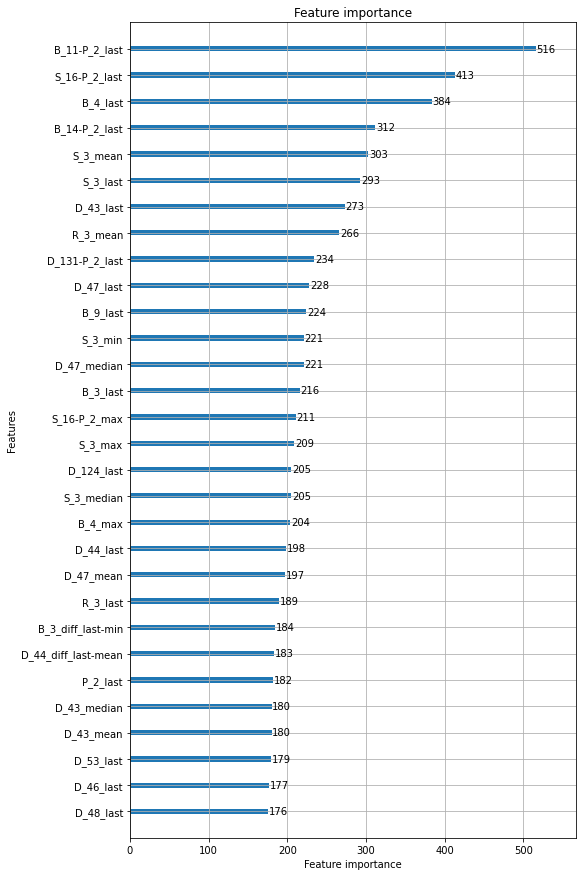

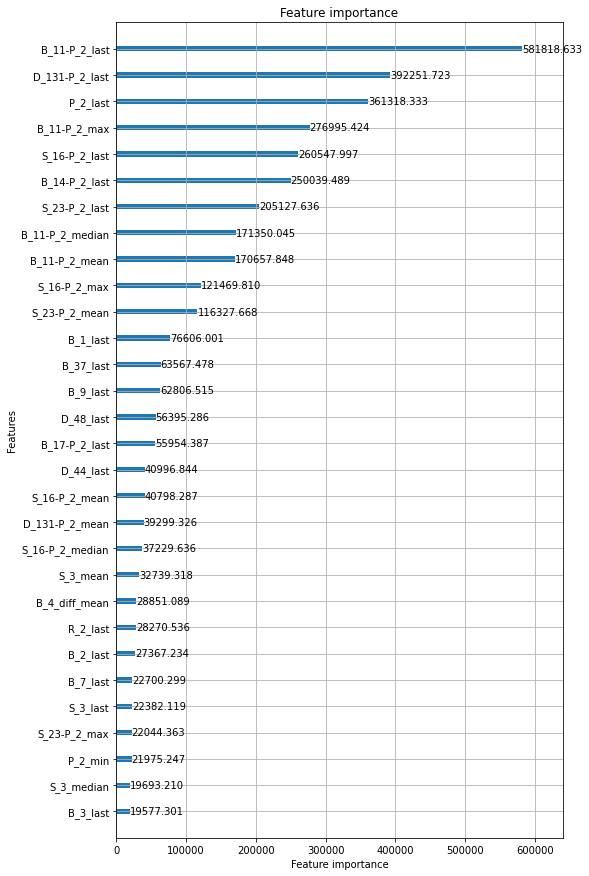

######################################## training model 5/5 ########################################


[50]	valid_0's amex_metric: 0.753039	valid_0's recall_at4: 0.605554	valid_0's norm_gini: 0.900523


[100]	valid_0's amex_metric: 0.763105	valid_0's recall_at4: 0.619987	valid_0's norm_gini: 0.906222


[150]	valid_0's amex_metric: 0.768491	valid_0's recall_at4: 0.627141	valid_0's norm_gini: 0.909841


[200]	valid_0's amex_metric: 0.775902	valid_0's recall_at4: 0.63825	valid_0's norm_gini: 0.913554


[250]	valid_0's amex_metric: 0.780357	valid_0's recall_at4: 0.644646	valid_0's norm_gini: 0.916068


[300]	valid_0's amex_metric: 0.782901	valid_0's recall_at4: 0.648054	valid_0's norm_gini: 0.917747


[350]	valid_0's amex_metric: 0.784605	valid_0's recall_at4: 0.650242	valid_0's norm_gini: 0.918968


[400]	valid_0's amex_metric: 0.787021	valid_0's recall_at4: 0.654071	valid_0's norm_gini: 0.91997


[450]	valid_0's amex_metric: 0.787861	valid_0's recall_at4: 0.654997	valid_0's norm_gini: 0.920726


[500]	valid_0's amex_metric: 0.789294	valid_0's recall_at4: 0.657269	valid_0's norm_gini: 0.921319


[550]	valid_0's amex_metric: 0.791353	valid_0's recall_at4: 0.660888	valid_0's norm_gini: 0.921818


[600]	valid_0's amex_metric: 0.792755	valid_0's recall_at4: 0.66337	valid_0's norm_gini: 0.92214


[650]	valid_0's amex_metric: 0.793154	valid_0's recall_at4: 0.663833	valid_0's norm_gini: 0.922475


[700]	valid_0's amex_metric: 0.793705	valid_0's recall_at4: 0.664591	valid_0's norm_gini: 0.92282


[750]	valid_0's amex_metric: 0.793318	valid_0's recall_at4: 0.663581	valid_0's norm_gini: 0.923056


[800]	valid_0's amex_metric: 0.793732	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.923294


[850]	valid_0's amex_metric: 0.794388	valid_0's recall_at4: 0.665222	valid_0's norm_gini: 0.923554


[900]	valid_0's amex_metric: 0.794147	valid_0's recall_at4: 0.664591	valid_0's norm_gini: 0.923703


[950]	valid_0's amex_metric: 0.793815	valid_0's recall_at4: 0.663707	valid_0's norm_gini: 0.923923


[1000]	valid_0's amex_metric: 0.79507	valid_0's recall_at4: 0.665979	valid_0's norm_gini: 0.92416


[1050]	valid_0's amex_metric: 0.796048	valid_0's recall_at4: 0.667705	valid_0's norm_gini: 0.924391


[1100]	valid_0's amex_metric: 0.796786	valid_0's recall_at4: 0.668967	valid_0's norm_gini: 0.924605


[1150]	valid_0's amex_metric: 0.797354	valid_0's recall_at4: 0.669935	valid_0's norm_gini: 0.924773


[1200]	valid_0's amex_metric: 0.797092	valid_0's recall_at4: 0.669262	valid_0's norm_gini: 0.924923


[1250]	valid_0's amex_metric: 0.797481	valid_0's recall_at4: 0.669935	valid_0's norm_gini: 0.925027


[1300]	valid_0's amex_metric: 0.797569	valid_0's recall_at4: 0.670019	valid_0's norm_gini: 0.925119


[1350]	valid_0's amex_metric: 0.797574	valid_0's recall_at4: 0.669935	valid_0's norm_gini: 0.925214


[1400]	valid_0's amex_metric: 0.797257	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925295


[1450]	valid_0's amex_metric: 0.7977	valid_0's recall_at4: 0.670019	valid_0's norm_gini: 0.925382


[1500]	valid_0's amex_metric: 0.797848	valid_0's recall_at4: 0.670229	valid_0's norm_gini: 0.925467


[1550]	valid_0's amex_metric: 0.797898	valid_0's recall_at4: 0.670229	valid_0's norm_gini: 0.925566


[1600]	valid_0's amex_metric: 0.798255	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.925608


[1650]	valid_0's amex_metric: 0.798949	valid_0's recall_at4: 0.672249	valid_0's norm_gini: 0.925649


[1700]	valid_0's amex_metric: 0.799132	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.925679


[1750]	valid_0's amex_metric: 0.798784	valid_0's recall_at4: 0.671828	valid_0's norm_gini: 0.92574


[1800]	valid_0's amex_metric: 0.79919	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.925794


[1850]	valid_0's amex_metric: 0.799043	valid_0's recall_at4: 0.672249	valid_0's norm_gini: 0.925838


[1900]	valid_0's amex_metric: 0.799446	valid_0's recall_at4: 0.673007	valid_0's norm_gini: 0.925885


[1950]	valid_0's amex_metric: 0.799269	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.925953


[2000]	valid_0's amex_metric: 0.799173	valid_0's recall_at4: 0.672333	valid_0's norm_gini: 0.926013


[2050]	valid_0's amex_metric: 0.79925	valid_0's recall_at4: 0.672459	valid_0's norm_gini: 0.92604


[2100]	valid_0's amex_metric: 0.799441	valid_0's recall_at4: 0.672796	valid_0's norm_gini: 0.926085


[2150]	valid_0's amex_metric: 0.799268	valid_0's recall_at4: 0.672417	valid_0's norm_gini: 0.926118


[2200]	valid_0's amex_metric: 0.799756	valid_0's recall_at4: 0.673343	valid_0's norm_gini: 0.92617


[2250]	valid_0's amex_metric: 0.799397	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.926209


[2300]	valid_0's amex_metric: 0.799807	valid_0's recall_at4: 0.673385	valid_0's norm_gini: 0.926229


[2350]	valid_0's amex_metric: 0.799847	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.926266


[2400]	valid_0's amex_metric: 0.800376	valid_0's recall_at4: 0.674437	valid_0's norm_gini: 0.926314


[2450]	valid_0's amex_metric: 0.800165	valid_0's recall_at4: 0.674016	valid_0's norm_gini: 0.926314


[2500]	valid_0's amex_metric: 0.799898	valid_0's recall_at4: 0.673469	valid_0's norm_gini: 0.926326


[2550]	valid_0's amex_metric: 0.800303	valid_0's recall_at4: 0.674269	valid_0's norm_gini: 0.926337


[2600]	valid_0's amex_metric: 0.799847	valid_0's recall_at4: 0.673343	valid_0's norm_gini: 0.92635


[2650]	valid_0's amex_metric: 0.800099	valid_0's recall_at4: 0.673806	valid_0's norm_gini: 0.926391


[2700]	valid_0's amex_metric: 0.799905	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.926382


[2750]	valid_0's amex_metric: 0.800006	valid_0's recall_at4: 0.673638	valid_0's norm_gini: 0.926375


[2800]	valid_0's amex_metric: 0.799988	valid_0's recall_at4: 0.673596	valid_0's norm_gini: 0.926379


[2850]	valid_0's amex_metric: 0.800308	valid_0's recall_at4: 0.674227	valid_0's norm_gini: 0.926389


[2900]	valid_0's amex_metric: 0.800312	valid_0's recall_at4: 0.674227	valid_0's norm_gini: 0.926398


[2950]	valid_0's amex_metric: 0.800023	valid_0's recall_at4: 0.673638	valid_0's norm_gini: 0.926409


[3000]	valid_0's amex_metric: 0.800028	valid_0's recall_at4: 0.673638	valid_0's norm_gini: 0.926418


[3050]	valid_0's amex_metric: 0.800492	valid_0's recall_at4: 0.674563	valid_0's norm_gini: 0.926421


[3100]	valid_0's amex_metric: 0.800288	valid_0's recall_at4: 0.674143	valid_0's norm_gini: 0.926434


[3150]	valid_0's amex_metric: 0.800578	valid_0's recall_at4: 0.67469	valid_0's norm_gini: 0.926466


[3200]	valid_0's amex_metric: 0.800475	valid_0's recall_at4: 0.674479	valid_0's norm_gini: 0.926471


[3250]	valid_0's amex_metric: 0.800621	valid_0's recall_at4: 0.674774	valid_0's norm_gini: 0.926468


[3300]	valid_0's amex_metric: 0.800686	valid_0's recall_at4: 0.6749	valid_0's norm_gini: 0.926471


[3350]	valid_0's amex_metric: 0.800747	valid_0's recall_at4: 0.675026	valid_0's norm_gini: 0.926468


[3400]	valid_0's amex_metric: 0.800289	valid_0's recall_at4: 0.674101	valid_0's norm_gini: 0.926478


[3450]	valid_0's amex_metric: 0.800646	valid_0's recall_at4: 0.674816	valid_0's norm_gini: 0.926476


[3500]	valid_0's amex_metric: 0.800935	valid_0's recall_at4: 0.675405	valid_0's norm_gini: 0.926466


[3550]	valid_0's amex_metric: 0.800918	valid_0's recall_at4: 0.675363	valid_0's norm_gini: 0.926473


[3600]	valid_0's amex_metric: 0.800797	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.926484


[3650]	valid_0's amex_metric: 0.800994	valid_0's recall_at4: 0.675489	valid_0's norm_gini: 0.926498


[3700]	valid_0's amex_metric: 0.800862	valid_0's recall_at4: 0.675237	valid_0's norm_gini: 0.926487


[3750]	valid_0's amex_metric: 0.800968	valid_0's recall_at4: 0.675447	valid_0's norm_gini: 0.926488


[3800]	valid_0's amex_metric: 0.80078	valid_0's recall_at4: 0.675068	valid_0's norm_gini: 0.926492


[3850]	valid_0's amex_metric: 0.800948	valid_0's recall_at4: 0.675405	valid_0's norm_gini: 0.926492


[3900]	valid_0's amex_metric: 0.800408	valid_0's recall_at4: 0.674353	valid_0's norm_gini: 0.926462


[3950]	valid_0's amex_metric: 0.80064	valid_0's recall_at4: 0.674816	valid_0's norm_gini: 0.926464


[4000]	valid_0's amex_metric: 0.800495	valid_0's recall_at4: 0.674521	valid_0's norm_gini: 0.926469


[4050]	valid_0's amex_metric: 0.800494	valid_0's recall_at4: 0.674521	valid_0's norm_gini: 0.926466


[4100]	valid_0's amex_metric: 0.800195	valid_0's recall_at4: 0.673932	valid_0's norm_gini: 0.926458


[4150]	valid_0's amex_metric: 0.799967	valid_0's recall_at4: 0.673469	valid_0's norm_gini: 0.926465


[4200]	valid_0's amex_metric: 0.800261	valid_0's recall_at4: 0.674058	valid_0's norm_gini: 0.926464


[4250]	valid_0's amex_metric: 0.800763	valid_0's recall_at4: 0.675068	valid_0's norm_gini: 0.926458


[4300]	valid_0's amex_metric: 0.800376	valid_0's recall_at4: 0.674269	valid_0's norm_gini: 0.926483


[4350]	valid_0's amex_metric: 0.800223	valid_0's recall_at4: 0.673974	valid_0's norm_gini: 0.926472


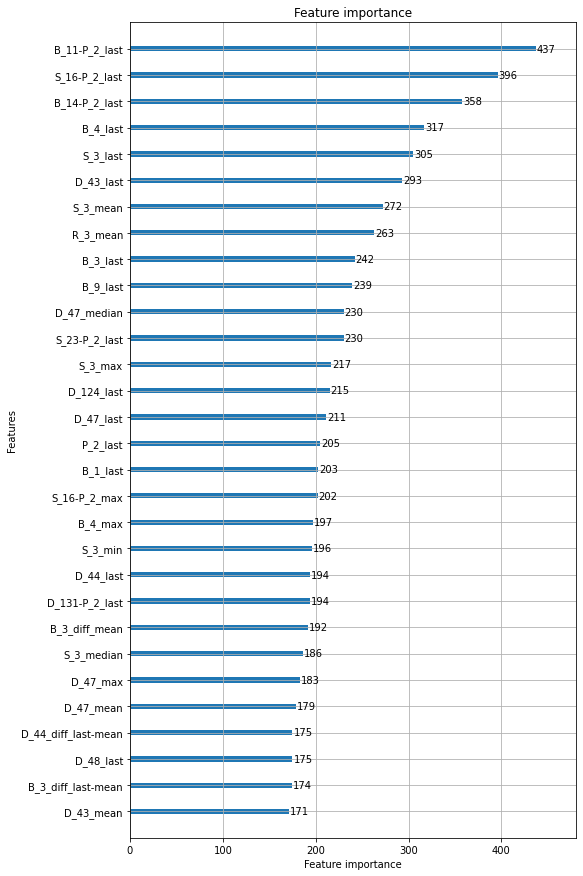

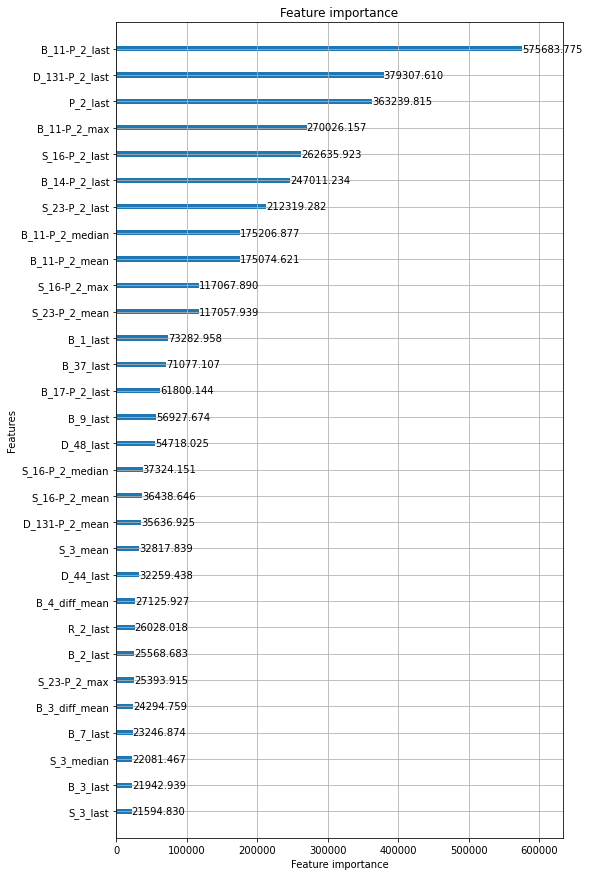

Training time: 33.164383844534555 min.


OOF recall_at4: 0.66396808832935


OOF normalized_gini: 0.9241214092965842


OOF competition metric: 0.794044748812967


CPU times: user 11h 45min 19s, sys: 37.3 s, total: 11h 45min 57s
Wall time: 33min 15s


In [11]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_models.append(models)
    all_oof_dfs.append(oof)
    
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"/model-cv{repetition}-fold{fold}.txt")
          
    del _train, folds; gc.collect()

In [12]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.663968,0.924121,0.794045



mean:


recall_at4    0.663968
gini          0.924121
metric        0.794045
dtype: float64


std:


recall_at4   NaN
gini         NaN
metric       NaN
dtype: float64

In [13]:
del train
gc.collect()

21

***
## make predictions and submit

In [14]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)    

In [15]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [16]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

CPU times: user 35min 54s, sys: 14 s, total: 36min 8s
Wall time: 1min 45s


In [17]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.51 s, sys: 971 ms, total: 4.48 s
Wall time: 4.64 s


***